<a href="https://colab.research.google.com/github/Min-young-15/AI_1/blob/main/EfficientNet_B3_%2B_ResNet18(%E1%84%8C%E1%85%A6%E1%84%8E%E1%85%AE%E1%86%AF%E1%84%8B%E1%85%AD%E1%86%BC)_%E1%84%89%E1%85%AE%E1%84%8C%E1%85%A5%E1%86%BC%E1%84%8B%E1%85%AA%E1%86%AB%E1%84%85%E1%85%AD_%E1%84%8E%E1%85%AC%E1%84%8C%E1%85%A9%E1%86%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 압축 해제

import zipfile
from tqdm import tqdm
import os

zip_path = "/content/drive/MyDrive/인공지능1/food-101.zip"
extract_path = "/content/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    files = zip_ref.infolist()
    for file in tqdm(files, desc="Unzip", unit="file"):
        zip_ref.extract(member=file, path=extract_path)

Unzip: 100%|██████████| 101112/101112 [00:53<00:00, 1893.27file/s]


In [4]:
# 설정값

import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import json

# 하이퍼파라미터 설정
IMG_SIZE = 300        # 이미지 사이즈
BATCH_SIZE = 16       # 배치 사이즈
EPOCHS = 30           # 학습 횟수
LEARNING_RATE = 1e-4  # 학습률
WEIGHT_DECAY = 1e-4   # 정규화

# GPU 할당
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
!nvidia-smi   # GPU 할당 확인

Mon Jun 16 06:13:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
# txt 파일 분할

import os
import glob
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

# 랜덤값 고정 (재현성 보장)
SEED = 42
random.seed(SEED)

# 이미지 경로 설정
DATA_ROOT = "/content/content/food-101/images"
all_data = []

# 각 클래스별 이미지 경로 수집
for class_name in sorted(os.listdir(DATA_ROOT)):
    class_dir = os.path.join(DATA_ROOT, class_name)
    image_paths = glob.glob(os.path.join(class_dir, "*.jpg"))
    for path in image_paths:
        all_data.append((path, class_name))

# 클래스별 그룹핑
class_to_images = defaultdict(list)
for path, class_name in all_data:
    class_to_images[class_name].append(path)

# 비율대로 분할 (6:2:2)
# 클래스별로 따로 분할하기 때문에 클래스 불균형 없이 공평하게 분할됨
train_paths, val_paths, test_paths = [], [], []   # 저장 경로 리스트

for class_name, images in class_to_images.items():

    # 60%를 train, 나머지 40%는 temp에 저장 (6:4 분할)
    train, temp = train_test_split(images, test_size=0.4, random_state=SEED)
    # temp를 5:5로 나눠서 val / test 각각 20%씩 분할
    val, test = train_test_split(temp, test_size=0.5, random_state=SEED)

    train_paths.extend([(p, class_name) for p in train])
    val_paths.extend([(p, class_name) for p in val])
    test_paths.extend([(p, class_name) for p in test])

print(f"총 이미지 수: {len(all_data)}")
print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

# 저장 경로 설정
SAVE_DIR = "/content/drive/MyDrive/인공지능1"

# 분할된 txt 파일 저장 함수
def save_txt(pairs, filename):
    with open(os.path.join(SAVE_DIR, filename), 'w') as f:
        for path, class_name in pairs:
            rel_path = os.path.relpath(path, DATA_ROOT)
            f.write(f"{rel_path}\n")

# 분할 저장
save_txt(train_paths, "train_split.txt")
save_txt(val_paths, "val_split.txt")
save_txt(test_paths, "test_split.txt")

총 이미지 수: 101000
Train: 60600, Val: 20200, Test: 20200


In [7]:
# ImageFolder 사용 DataLoader 생성

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # 텐서로 변환, 각 채널을 평균/표준편차로 정규화
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],   # 평균
                         [0.229, 0.224, 0.225])   # 표준편차
])

# 데이터 증강해서 학습
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),     # 이미지 크기 통일
    transforms.RandomHorizontalFlip(),           # 랜덤으로 좌우 반전
    transforms.RandomRotation(10),               # 랜덤으로 회전 (10% 범위)
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),    # 밝기, 대비, 채도, 색조 변경
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 랜덤으로 이동 (10% 범위)
    transforms.ToTensor(),                        # 이미지를 텐서로 변환
    transforms.Normalize([0.485, 0.456, 0.406],   # 정규화
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 전체 dataset 로드
dataset_all = ImageFolder(DATA_ROOT, transform=None)

rel_path_to_idx = {
    os.path.splitext('/'.join(p.split('/')[-2:]))[0]: i
    for i, (p, _) in enumerate(dataset_all.imgs)
}

def load_indices(txt_path):
    with open(txt_path) as f:
        rel_paths = [line.strip() for line in f]
    return [rel_path_to_idx[os.path.splitext(p)[0]] for p in rel_paths]

train_indices = load_indices("/content/drive/MyDrive/인공지능1/train_split.txt")
val_indices   = load_indices("/content/drive/MyDrive/인공지능1/val_split.txt")
test_indices  = load_indices("/content/drive/MyDrive/인공지능1/test_split.txt")

# dataset에 transform 적용
train_dataset = ImageFolder(DATA_ROOT, transform=train_transform)
test_dataset  = ImageFolder(DATA_ROOT, transform=test_transform)

# subset 구성
train_set = Subset(train_dataset, train_indices)
val_set   = Subset(test_dataset, val_indices)
test_set  = Subset(test_dataset, test_indices)

# DataLoader 생성
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)   # 학습용 데이터는 shuffle=True로 섞기
val_loader   = DataLoader(val_set, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

1) EfficientNet-B3

In [8]:
# 1-1. EfficientNet-B3 모델 정의

NUM_CLASSES = len(dataset_all.classes)

from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

# 모델 정의
weights = EfficientNet_B3_Weights.IMAGENET1K_V1
model = efficientnet_b3(weights=weights)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 146MB/s]


In [9]:
# 1-2. EfficientNet B3 학습 루프

from tqdm import tqdm
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 학습곡선 작성을 위한 리스트 생성
train_losses = []
val_losses = []
val_accuracies = []

# val_loss가 감소하지 않을 때 학습률을 줄이기 위한 스케줄러
scheduler = ReduceLROnPlateau(
    optimizer,           # 옵티마이저 객체
    mode='min',          # val_loss가 최소가 되는 방향으로
    factor=0.5,          # 학습률을 50%로 줄이기
    patience=3,          # 3 epoch 연속으로 val_loss가 개선되지 않으면 학습률 감소
    verbose=True         # 학습률이 줄어들 때 로그 출력
)

# 전체 학습 시작 시간 저장
total_start = time.time()

# 초기화
best_val_loss = float('inf')    # 성능 제일 좋은 거 저장
patience = 5                    # early stopping 기준
counter = 0                     # 개선되지 않은 epoch 횟수

# 반복 학습 루프
for epoch in range(EPOCHS):
    epoch_start = time.time()
    model.train()
    train_loss = 0              # 누적 train_loss 초기화

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=True)
    for images, labels in train_bar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)               # forward pass
        loss = criterion(outputs, labels)     # Train_Loss 계산

        optimizer.zero_grad()                   # 기울기 초기화
        loss.backward()                         # 역전파
        optimizer.step()                        # 파라미터 업데이트

        train_loss += loss.item()               # Train_Loss 누적
        train_bar.set_postfix(loss=loss.item())

    # Validation set으로 검증
    model.eval()                                # validation set 평가
    val_loss, correct, total = 0, 0, 0          # 초기화

    # 평가할 때는 역전파 x
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)   # Val_Loss 계산
            val_loss += loss.item()             # Val_Loss 누적

            preds = torch.argmax(outputs, dim=1)        # 가장 높은 확률 클래스 선택
            correct += (preds == labels).sum().item()   # 예측과 실제 비교해서 맞은 개수 카운트
            total += labels.size(0)                     # 전체 개수


    val_acc = correct / total                       # 정확도 계산
    elapsed = time.time() - total_start             # 지금까지 총 소요 시간
    avg_epoch = elapsed / (epoch + 1)               # 평균 epoch 소요 시간
    remaining = avg_epoch * (EPOCHS - epoch - 1)    # 남은 학습 예상 시간


    # 기록 저장
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # 스케줄러 동작
    scheduler.step(val_loss)

    # 현재 epoch 결과 출력
    print(f"[EfficientNet-B3] Epoch {epoch+1} | Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%} | "
          f"Time: {time.time() - epoch_start:.1f}s | ETA: {remaining/60:.1f} min")

    # early stopping + Best Model 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss    # 현재까지 가장 낮은 val_loss로 업데이트
        counter = 0                 # 초기화
        MODEL_PATH = "/content/drive/MyDrive/인공지능1/efficientnet_b3_food101_best.pth"
        torch.save(model.state_dict(), MODEL_PATH)  # 성능 가장 좋은 시점 저장
    else:
        counter += 1
        # val_loss가 개선되지 않는 epoch가 5회 연속되면(patience = 5) 학습 중단됨
        if counter >= patience:
            print("🛑 [EfficientNet-B3] Early stopping triggered.")
            break

print(f"\n전체 학습 시간: {(time.time() - total_start)/60:.2f} 분")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/30 [Train]: 100%|██████████| 3788/3788 [18:10<00:00,  3.47it/s, loss=1.46]


[EfficientNet-B3] Epoch 1 | Train Loss: 7468.0664 | Val Loss: 1156.1133 | Val Acc: 75.64% | Time: 1182.4s | ETA: 571.5 min


Epoch 2/30 [Train]: 100%|██████████| 3788/3788 [18:12<00:00,  3.47it/s, loss=1.8]


[EfficientNet-B3] Epoch 2 | Train Loss: 3887.7114 | Val Loss: 956.3293 | Val Acc: 79.81% | Time: 1183.6s | ETA: 552.6 min


Epoch 3/30 [Train]: 100%|██████████| 3788/3788 [18:12<00:00,  3.47it/s, loss=0.474]


[EfficientNet-B3] Epoch 3 | Train Loss: 3005.2061 | Val Loss: 898.4232 | Val Acc: 81.22% | Time: 1183.4s | ETA: 532.8 min


Epoch 4/30 [Train]: 100%|██████████| 3788/3788 [18:11<00:00,  3.47it/s, loss=0.395]


[EfficientNet-B3] Epoch 4 | Train Loss: 2453.8956 | Val Loss: 867.3852 | Val Acc: 82.23% | Time: 1182.7s | ETA: 513.0 min


Epoch 5/30 [Train]: 100%|██████████| 3788/3788 [18:11<00:00,  3.47it/s, loss=0.307]


[EfficientNet-B3] Epoch 5 | Train Loss: 2057.5794 | Val Loss: 895.8751 | Val Acc: 82.39% | Time: 1183.3s | ETA: 493.2 min


Epoch 6/30 [Train]: 100%|██████████| 3788/3788 [18:04<00:00,  3.49it/s, loss=0.386]


[EfficientNet-B3] Epoch 6 | Train Loss: 1764.9266 | Val Loss: 890.1178 | Val Acc: 82.67% | Time: 1175.3s | ETA: 472.9 min


Epoch 7/30 [Train]: 100%|██████████| 3788/3788 [18:09<00:00,  3.48it/s, loss=0.613]


[EfficientNet-B3] Epoch 7 | Train Loss: 1516.9987 | Val Loss: 929.9209 | Val Acc: 82.69% | Time: 1181.2s | ETA: 453.2 min


Epoch 8/30 [Train]: 100%|██████████| 3788/3788 [18:04<00:00,  3.49it/s, loss=0.77]


[EfficientNet-B3] Epoch 8 | Train Loss: 1348.1612 | Val Loss: 920.3978 | Val Acc: 82.91% | Time: 1174.3s | ETA: 433.1 min


Epoch 9/30 [Train]: 100%|██████████| 3788/3788 [18:05<00:00,  3.49it/s, loss=0.372]


[EfficientNet-B3] Epoch 9 | Train Loss: 912.3801 | Val Loss: 909.8115 | Val Acc: 83.76% | Time: 1176.4s | ETA: 413.2 min
🛑 [EfficientNet-B3] Early stopping triggered.

전체 학습 시간: 177.10 분


In [10]:
# 오버피팅 되기 전에 저장된 모델 불러오기 (early stopping)

model.load_state_dict(torch.load("/content/drive/MyDrive/인공지능1/efficientnet_b3_food101_best.pth"))

<All keys matched successfully>

In [11]:
# 1-3. 성능 평가

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# test set 평가
model.eval()

# 예측값, 실제값 리스트 초기화
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="평가"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

if hasattr(test_loader.dataset, 'dataset'):
    class_names = test_loader.dataset.dataset.classes
else:
    class_names = test_loader.dataset.classes

# 정확도 출력
accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\n✅ [EfficientNet-B3] Test Accuracy: {accuracy:.2%}")

# Classification Report
print("\n[EfficientNet-B3] Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

평가: 100%|██████████| 1263/1263 [01:31<00:00, 13.81it/s]


✅ [EfficientNet-B3] Test Accuracy: 82.80%

[EfficientNet-B3] Classification Report:
                         precision    recall  f1-score   support

              apple_pie       0.64      0.70      0.67       200
         baby_back_ribs       0.82      0.84      0.83       200
                baklava       0.90      0.88      0.89       200
         beef_carpaccio       0.87      0.82      0.85       200
           beef_tartare       0.78      0.81      0.80       200
             beet_salad       0.75      0.70      0.73       200
               beignets       0.85      0.88      0.86       200
               bibimbap       0.88      0.93      0.90       200
          bread_pudding       0.74      0.63      0.68       200
      breakfast_burrito       0.80      0.84      0.82       200
             bruschetta       0.79      0.76      0.78       200
           caesar_salad       0.94      0.86      0.90       200
                cannoli       0.86      0.91      0.89       200
    

In [12]:
# 1-4. 샘플 이미지 예측 + JSON 매핑 함수 선언

def load_food_info(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return {item["food"]: item for item in data}

# 이미지 경로를 받아 예측 결과와 영양 정보를 출력하고 이미지를 시각화
def predict_image_with_info(img_path, model, transform, class_names, food_info_dict=None):

    # 이미지 로드 및 시각화
    img = Image.open(img_path).convert("RGB")
    plt.imshow(img)
    plt.title("원본 이미지")
    plt.axis("off")
    plt.show()

    # 전처리 및 모델 예측
    input_tensor = transform(img).unsqueeze(0).to(DEVICE)
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        pred_idx = torch.argmax(output, dim=1).item()
        prob = torch.softmax(output, dim=1)[0][pred_idx].item()

    # 클래스 이름 매핑
    predicted_class = class_names[pred_idx]
    print(f"\n✅ 예측 결과: {predicted_class} ({prob:.2%})")

    # JSON 기반 영양 정보 출력 (옵션)
    if food_info_dict:
        info = food_info_dict.get(predicted_class)
        if info:
            print("* 영양 정보 (100g 기준):")
            print(f"  열량: {info['calories_per_100g']} kcal")
            print(f"  단백질: {info['protein_per_100g']} g")
            print(f"  탄수화물: {info['carbohydrates_per_100g']} g")
            print(f"  지방: {info['fats_per_100g']} g")
            print(f"  섬유질: {info['fiber_per_100g']} g")
            print(f"  당: {info['sugars_per_100g']} g")
            print(f"  나트륨: {info['sodium_per_100g']} mg")
        else:
            print("해당 음식의 영양 정보가 없음")
    else:
        print("영양 정보 매핑 없이 예측만 수행")

    # 예측 결과와 확률 포함된 이미지 출력
    plt.imshow(img)
    plt.title(f"{predicted_class} ({prob:.2%})")
    plt.axis("off")
    plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


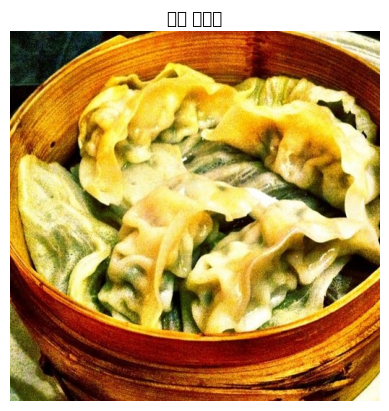


✅ 예측 결과: gyoza (77.28%)
* 영양 정보 (100g 기준):
  열량: 200.0 kcal
  단백질: 8.0 g
  탄수화물: 20.0 g
  지방: 8.0 g
  섬유질: 2.0 g
  당: 2.0 g
  나트륨: 300.0 mg


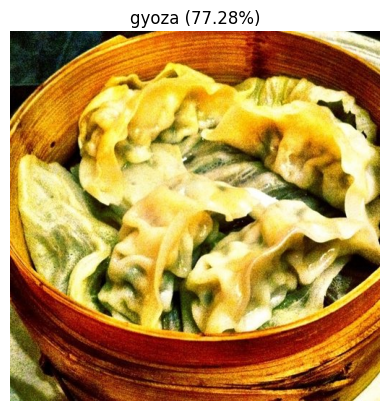

In [13]:
# 1-5. 예측 실행

JSON_PATH = "/content/drive/MyDrive/인공지능1/mapped_train.json"
food_info_dict = load_food_info(JSON_PATH)

import random
import os

# 자동으로 무작위 샘플 경로 선택
def get_random_image_path(data_root):
    class_name = random.choice(os.listdir(data_root))
    image_name = random.choice(os.listdir(os.path.join(data_root, class_name)))
    return os.path.join(data_root, class_name, image_name)

SAMPLE_IMG = get_random_image_path("/content/content/food-101/images")

# ImageFolder 이용해서 폴더 구조로부터 클래스 정보 자동 생성
from torchvision.datasets import ImageFolder
temp_dataset = ImageFolder(DATA_ROOT)
idx_to_class = {v: k for k, v in temp_dataset.class_to_idx.items()}

# 리스트로 변환 (인덱스 → 클래스 이름)
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

# 예측 실행
predict_image_with_info(SAMPLE_IMG, model, test_transform, class_names, food_info_dict)

In [14]:
# 1-6. 함수 선언

# 학습 곡선 (Loss + Accuracy) 시각화 함수

import matplotlib.pyplot as plt

def plot_loss_accuracy(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss 곡선
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train/Val Loss")
    plt.legend()

    # Accuracy 곡선
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Val Accuracy", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Confusion Matrix (101×101 색상만) 시각화 함수

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def plot_confusion_matrix(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, cmap="Blues", xticklabels=False, yticklabels=False)
    plt.title("Confusion Matrix (101×101)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

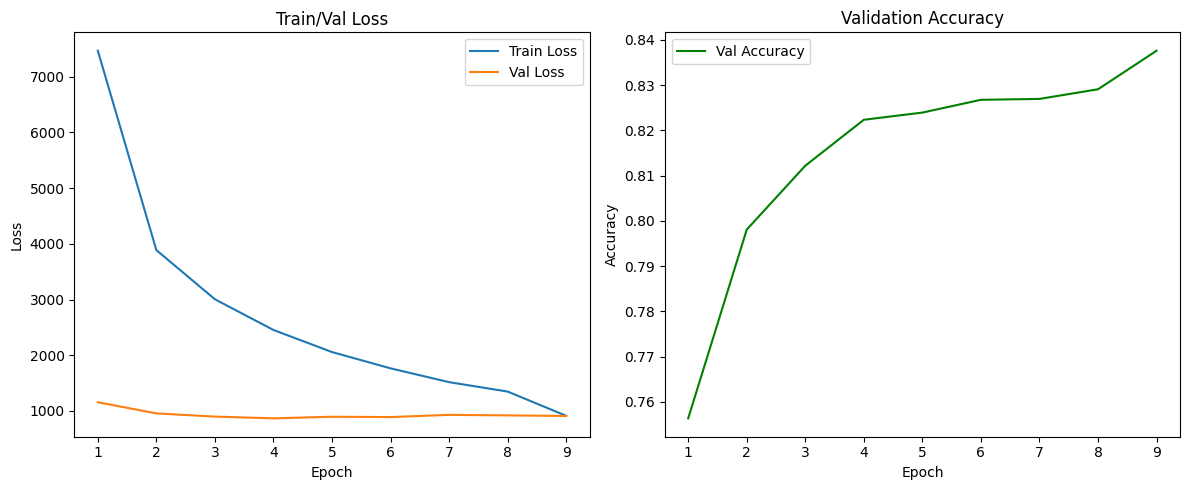

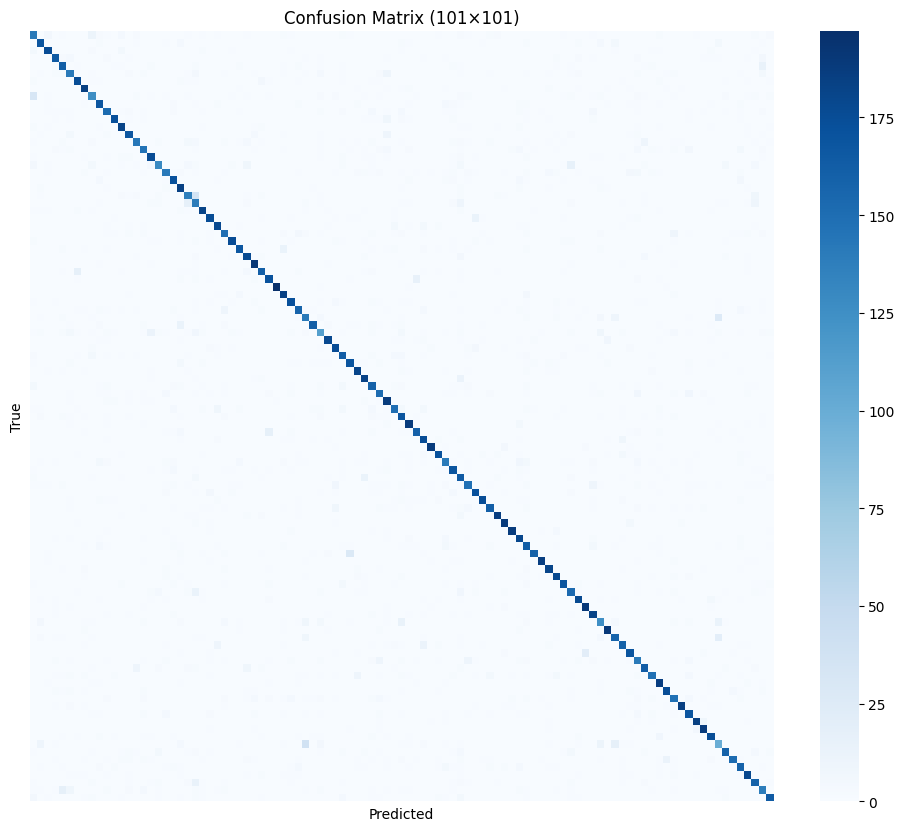

In [15]:
# 1-7. 시각화 함수 호출
plot_loss_accuracy(train_losses, val_losses, val_accuracies)
plot_confusion_matrix(y_true, y_pred)

2) ResNet-18

In [16]:
# 2-1. 모델 정의

import torchvision.models as models
import torch.nn as nn

resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 101)  # Food-101
resnet18 = resnet18.to(DEVICE)

# 손실 함수 / 옵티마이저 / 스케줄러 - EfficientNet과 동일
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(resnet18.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler_resnet = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_resnet, mode='min', factor=0.5, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

In [ ]:
# 2-2. 학습 루프

best_val_loss_resnet = float('inf')   # 성능 제일 좋은 거 저장
patience_resnet = 5                   # early stopping 기준
counter_resnet = 0                    # 개선되지 않은 epoch 횟수
EPOCHS = 30                           # 학습 횟수

# 학습곡선 작성을 위한 리스트 생성
train_losses_resnet = []
val_losses_resnet = []
val_accuracies_resnet = []

for epoch in range(EPOCHS):
    resnet18.train()
    train_loss = 0        # 누적 train_loss 초기화
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=True)

    for images, labels in train_bar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = resnet18(images)                    # forward pass
        loss = criterion_resnet(outputs, labels)      # Train_Loss 계산

        optimizer_resnet.zero_grad()                  # 기울기 초기화
        loss.backward()                               # 역전파
        optimizer_resnet.step()                       # 파라미터 업데이트

        train_loss += loss.item()                     # Train_Loss 누적
        train_bar.set_postfix(loss=loss.item())

    train_losses_resnet.append(train_loss)  # 루프 밖에서 1회 저장

    # Validation set으로 검증
    resnet18.eval()                         # validation set 평가
    val_loss, correct, total = 0, 0, 0      # 초기화

    # 평가할 때는 역전파 x
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = resnet18(images)
            loss = criterion_resnet(outputs, labels)    # Val_Loss 계산
            val_loss += loss.item()                     # Val_Loss 누적

            preds = torch.argmax(outputs, dim=1)        # 가장 높은 확률 클래스 선택
            correct += (preds == labels).sum().item()   # 예측과 실제 비교해서 맞은 개수 카운트
            total += labels.size(0)                     # 전체 개수

    val_acc = correct / total                           # 정확도 계산

    # 기록 저장
    val_losses_resnet.append(val_loss)
    val_accuracies_resnet.append(val_acc)
    scheduler_resnet.step(val_loss)

    # 현재 epoch 결과 출력
    print(f"[ResNet18] Epoch {epoch+1} | Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")

    # early stopping + Best Model 저장
    if val_loss < best_val_loss_resnet:
        best_val_loss_resnet = val_loss       # 현재까지 가장 낮은 val_loss로 업데이트
        counter_resnet = 0                    # 초기화
        torch.save(resnet18.state_dict(), "/content/drive/MyDrive/인공지능1/resnet18_food101_best.pth")
    else:
        counter_resnet += 1
        # val_loss가 개선되지 않는 epoch가 5회 연속되면(patience = 5) 학습 중단됨
        if counter_resnet >= patience_resnet:
            print("🛑 [ResNet18] Early stopping")
            break


Epoch 1/30: 100%|██████████| 3788/3788 [05:45<00:00, 10.95it/s, loss=2.35]


[ResNet18] Epoch 1 | Train Loss: 8391.2836 | Val Loss: 1776.7112 | Val Acc: 63.26%


Epoch 2/30: 100%|██████████| 3788/3788 [05:48<00:00, 10.88it/s, loss=0.801]


[ResNet18] Epoch 2 | Train Loss: 5432.1578 | Val Loss: 1575.6403 | Val Acc: 67.79%


Epoch 3/30: 100%|██████████| 3788/3788 [05:50<00:00, 10.82it/s, loss=1.12]


[ResNet18] Epoch 3 | Train Loss: 4588.7231 | Val Loss: 1411.8761 | Val Acc: 70.60%


Epoch 4/30: 100%|██████████| 3788/3788 [05:49<00:00, 10.83it/s, loss=1.19]


[ResNet18] Epoch 4 | Train Loss: 4034.8048 | Val Loss: 1411.2029 | Val Acc: 71.77%


Epoch 5/30: 100%|██████████| 3788/3788 [05:49<00:00, 10.84it/s, loss=1.47]


[ResNet18] Epoch 5 | Train Loss: 3627.8794 | Val Loss: 1404.4909 | Val Acc: 72.03%


Epoch 6/30: 100%|██████████| 3788/3788 [05:49<00:00, 10.84it/s, loss=0.303]


[ResNet18] Epoch 6 | Train Loss: 3304.7076 | Val Loss: 1367.2560 | Val Acc: 72.67%


Epoch 7/30:  95%|█████████▌| 3603/3788 [05:32<00:16, 10.90it/s, loss=0.794]

In [ ]:
# 2-3. ResNet18 성능평가

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# 예측값, 실제값 리스트 초기화
resnet_preds = []
resnet_labels = []

# 모델 로드
resnet18 = models.resnet18(pretrained=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 101)
resnet18.load_state_dict(torch.load("/content/drive/MyDrive/인공지능1/resnet18_food101_best.pth"))
resnet18 = resnet18.to(DEVICE)
resnet18.eval()

# 예측 수행
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="[ResNet18] Test Evaluation"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = resnet18(images)
        preds = torch.argmax(outputs, dim=1)

        resnet_preds.extend(preds.cpu().numpy())
        resnet_labels.extend(labels.cpu().numpy())

# 정확도 출력
resnet_accuracy = np.mean(np.array(resnet_preds) == np.array(resnet_labels))
print(f"\n✅ [ResNet18] Test Accuracy: {resnet_accuracy:.2%}")

# 클래스 이름 추출
if hasattr(test_loader.dataset, 'dataset'):
    class_names = test_loader.dataset.dataset.classes
else:
    class_names = test_loader.dataset.classes

In [ ]:
# 2-4. 시각화 함수 선언

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 학습 곡선 (Loss + Accuracy) 시각화 함수

def plot_resnet_curves(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss 곡선
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("ResNet18 Loss Curve")
    plt.legend()

    # Accuracy 곡선
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Val Accuracy', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("ResNet18 Val Accuracy Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Confusion Matrix (101×101 색상만) 시각화 함수

from sklearn.metrics import confusion_matrix

def plot_resnet_confusion_matrix(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, cmap="Blues", xticklabels=False, yticklabels=False)
    plt.title("Confusion Matrix (101×101)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [ ]:
# 2-5. 시각화 함수 호출

plot_resnet_curves(train_losses_resnet, val_losses_resnet, val_accuracies_resnet)
plot_resnet_confusion_matrix(resnet_labels, resnet_preds)

3) 앙상블 모델

In [ ]:
# 앙상블 평가

from torchvision.models import efficientnet_b3
import torch.nn as nn

# EfficientNet-b3 모델 구성 및 weight 로드
model_eff = efficientnet_b3(pretrained=False)                                                               # 사전 학습 비사용
model_eff.classifier[1] = nn.Linear(model_eff.classifier[1].in_features, 101)                               # 출력 클래스 101개로 변경
model_eff.load_state_dict(torch.load("/content/drive/MyDrive/인공지능1/efficientnet_b3_food101_best.pth"))    # 저장된 가중치 로드
model_eff = model_eff.to(DEVICE)                                                                            # GPU 할당
model_eff.eval()                                                                                            # 평가 모드로 설정

# ResNet-18 모델 구성 및 weight 로드
resnet18 = models.resnet18(pretrained=False)                                                          # 사전 학습 비사용
resnet18.fc = nn.Linear(resnet18.fc.in_features, 101)                                                 # 출력 클래스 101개로 변경
resnet18.load_state_dict(torch.load("/content/drive/MyDrive/인공지능1/resnet18_food101_best.pth"))      # 저장된 가중치 로드
resnet18 = resnet18.to(DEVICE)                                                                        # GPU 할당
resnet18.eval()                                                                                       # 평가 모드로 설정

# 앙상블 예측 수행 (Soft Voting 방식)
y_true, y_pred_ensemble = [], []    # 정답과 예측 결과 저장용 리스트

# 평가 중에는 gradient 계산 비활성화
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Ensemble Evaluation"):
        images = images.to(DEVICE)
        outputs_eff = model_eff(images)  # EfficientNet 예측 결과
        outputs_res = resnet18(images)   # ResNet 예측 결과

        # soft voting (두 모델의 출력 logit 평균)
        ensemble_outputs = (outputs_eff + outputs_res) / 2
        # argmax로 최종 클래스 선택
        preds = torch.argmax(ensemble_outputs, dim=1)

        # 결과 저장
        y_true.extend(labels.cpu().numpy())            # 정답 라벨 저장
        y_pred_ensemble.extend(preds.cpu().numpy())    # 예측 라벨 저장

# 평가 지표
from sklearn.metrics import classification_report, accuracy_score

# 예측 및 정답 비교
print(f"\n✅ [Ensemble] Accuracy: {accuracy_score(y_true, y_pred_ensemble):.2%}")
print("\n[Ensemble] Classification Report:")

# 클래스 이름 추출
class_names = test_loader.dataset.dataset.classes

# 리포트 출력
print(classification_report(y_true, y_pred_ensemble, target_names=class_names))


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred_ensemble)

# 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", square=True, cbar=True, xticklabels=False, yticklabels=False)
plt.title("Confusion Matrix (101×101)", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.tight_layout()
plt.show()


4) 영양정보 매핑

In [ ]:
# 예측 결과에 JSON 파일 영양정보 매핑
import os
import random
import json
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# JSON 정보 불러오기
def load_food_info(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return {item["food"]: item for item in data}

# 무작위 이미지 경로 추출 (경로 + 실제 클래스)
def get_random_image_with_label(data_root):
    class_name = random.choice(os.listdir(data_root))
    img_name = random.choice(os.listdir(os.path.join(data_root, class_name)))
    return os.path.join(data_root, class_name, img_name), class_name

# 예측 + 매핑 + 시각화 함수
def predict_and_map_random_sample(data_root, model1, model2, transform, class_names, food_info_dict):
    # 무작위 이미지 및 실제 클래스
    img_path, true_class = get_random_image_with_label(data_root)
    img = Image.open(img_path).convert("RGB")

    # 전처리
    input_tensor = transform(img).unsqueeze(0).to(DEVICE)

    # 앙상블 예측
    with torch.no_grad():
        out1 = F.softmax(model1(input_tensor), dim=1)
        out2 = F.softmax(model2(input_tensor), dim=1)
        ensemble_output = (out1 + out2) / 2
        pred_idx = torch.argmax(ensemble_output, dim=1).item()
        confidence = ensemble_output[0][pred_idx].item()

    pred_class = class_names[pred_idx]

    # 결과 출력
    print(f"\n랜덤 이미지: {img_path}")
    print(f"실제 클래스: {true_class}")
    print(f"예측 클래스: {pred_class} ({confidence:.2%})")

    # JSON 매핑 결과 출력
    if pred_class in food_info_dict:
        info = food_info_dict[pred_class]
        print(f"\n* 영양 정보 (100g 기준):")
        print(f" - 열량: {info['calories_per_100g']} kcal")
        print(f" - 단백질: {info['protein_per_100g']} g")
        print(f" - 탄수화물: {info['carbohydrates_per_100g']} g")
        print(f" - 지방: {info['fats_per_100g']} g")
        print(f" - 식이섬유: {info['fiber_per_100g']} g")
        print(f" - 당: {info['sugars_per_100g']} g")
        print(f" - 나트륨: {info['sodium_per_100g']} mg")
    else:
        print("⚠️ 해당 클래스에 대한 JSON 정보가 없음.")

    # 이미지 시각화
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"GT: {true_class} | Pred: {pred_class} ({confidence:.2%})")
    plt.show()


In [ ]:
# 기본 경로 설정
DATA_ROOT = "/content/content/food-101/images"
JSON_PATH = "/content/drive/MyDrive/인공지능1/mapped_train.json"
class_names = test_loader.dataset.dataset.classes  # Subset → ImageFolder 기준

# JSON 로드
food_info_dict = load_food_info(JSON_PATH)

# 예측 실행
predict_and_map_random_sample(DATA_ROOT, model_eff, resnet18, test_transform, class_names, food_info_dict)
